c:\Users\Before\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Top Positive Words:              word        CO
671120      worst  7.270277
655222      waste  6.384645
569146      stars -5.974227
266826      great -5.766102
67236       awful  5.484063
216488  excellent -5.398281
66628       avoid  5.363987
207074    enjoyed -5.044354
596690   terrible  5.008610
95133      boring  4.963620
390173       mess  4.822302
251475    garbage  4.723951
495193  redeeming  4.634742
468306     poorly  4.478857
294801   horrible  4.413345
Top Negative Words:                word   CO
100287    brilliatn  0.0
415611  nealfinally  0.0
579191     subsuper  0.0
579192   subsuquent  0.0
173234    despenser  0.0
415610    nealeddie  0.0
415606        neal4  0.0
92028   bodydoubled  0.0
18816        5raven  0.0
173231      despeja  0.0
579201      subtect  0.0
270938      guffamn  0.0
270939      guffans  0.0
579204  subteenaged  0.0
492124   reallizing  0.0


c:\Users\Before\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Before\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Average Accuracy: 0.6196046568802145


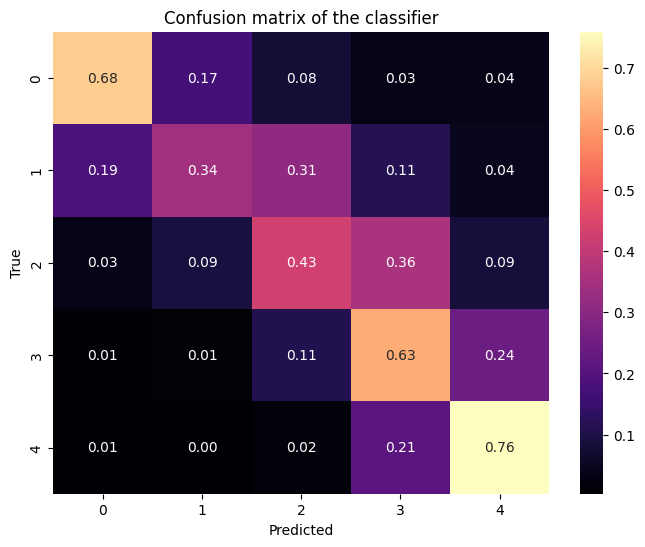

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import scipy
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load training data
data = pd.read_csv('train.csv')

# Downsize data with Score = 5.0 to balance classes (first method)
target_size = int(0.21 * len(data))  # Accuracy target adjustment, can increase or decrease this ratio
score_5_downsampled = data[data['Score'] == 5.0].sample(n=target_size, random_state=42)
other_scores = data[data['Score'] != 5.0]
data = pd.concat([score_5_downsampled, other_scores], ignore_index=True)
one_hot_encoder = OneHotEncoder(sparse_output=True)
encoded_product_user_ids = one_hot_encoder.fit_transform(data[['ProductId', 'UserId']])

# Impute missing values by replacing NaNs in text columns with empty strings
data['Text'] = data['Text'].apply(lambda x: '' if pd.isna(x) else x)
data['Summary'] = data['Summary'].apply(lambda x: '' if pd.isna(x) else x)
# Standardize numerical features
data['Good'] = data['HelpfulnessNumerator']
data['Bad'] = data['HelpfulnessDenominator'] - data['HelpfulnessNumerator']
scaler = StandardScaler()
data[['Good', 'Bad']] = scaler.fit_transform(data[['Good', 'Bad']])
data.drop(['HelpfulnessDenominator', 'HelpfulnessNumerator'], axis=1, inplace=True)
# Calculate TF-IDF for Text and Summary
# Initialize TF-IDF vectorizers for Text and Summary with common parameters
tfidf_params = {'input': 'content', 'analyzer': 'word', 'stop_words': 'english'}
text_vectorizer = TfidfVectorizer(**tfidf_params)
summary_vectorizer = TfidfVectorizer(**tfidf_params)

# Apply TF-IDF transformation on 'Text' and 'Summary' columns
text_matrix = text_vectorizer.fit_transform(data['Text'])
summary_matrix = summary_vectorizer.fit_transform(data['Summary'])

# Create a sparse matrix for numerical features (Good and Bad)
numerical_data = data[['Good', 'Bad']].values
numerical_features = scipy.sparse.csr_matrix(numerical_data)

# Combine text, summary, numerical, and encoded categorical features into a single feature matrix
all_features = scipy.sparse.hstack([
    text_matrix,
    summary_matrix,
    numerical_features,
    encoded_product_user_ids
])

# Separate test and train indices based on missing values in 'Score'
mask = data["Score"].isnull()
test_indices = np.where(mask)[0]
train_indices = np.where(~mask)[0]

# Here we apply the scipy method from outside source to reduce compuatation and 
# to store the one-hot encoded categorical features and TF-IDF vectors
train_X = scipy.sparse.csr_matrix(all_features)[train_indices]
test_X = scipy.sparse.csr_matrix(all_features)[test_indices]
train_Y = data['Score'].loc[~mask].reset_index(drop=True)

def CVKFold_Logistic(num_folds, features, labels):
    np.random.seed(1)
    cross_validator = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1)
    total_accuracy = 0
    final_confusion_matrix = None

    for fold_index, (train_idx, val_idx) in enumerate(cross_validator.split(features, labels)):
        train_features, val_features = features[train_idx], features[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]

        # Logistic Regression Model
        logistic_model = LogisticRegression(random_state=0, max_iter=1000)
        logistic_model.fit(train_features, train_labels)

        # Prediction and Accuracy Calculation for Validation Fold
        val_predictions = logistic_model.predict(val_features)
        fold_accuracy = accuracy_score(val_labels, val_predictions)
        total_accuracy += fold_accuracy

        # Compute confusion matrix
        if final_confusion_matrix is None:
            final_confusion_matrix = confusion_matrix(val_labels, val_predictions)
        else:
            final_confusion_matrix += confusion_matrix(val_labels, val_predictions)

        # Extract Important Words
        if fold_index == 0:  # Extract once on the first fold
            feature_names = text_vectorizer.get_feature_names_out()
            coefficients = logistic_model.coef_.flatten()[:len(feature_names)]
            
            # Combine words and coefficients, sort by influence
            important_words_df = pd.DataFrame({'word': feature_names, 'CO': coefficients})
            important_words_df = important_words_df.reindex(
                important_words_df['CO'].abs().sort_values(ascending=False).index
            )
            print("Top Positive Words:", important_words_df.head(10))
            print("Top Negative Words:", important_words_df.tail(10))

    # Calculate average accuracy
    average_accuracy = total_accuracy / num_folds
    print("Average Accuracy:", average_accuracy)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(final_confusion_matrix / final_confusion_matrix.sum(axis=1)[:, np.newaxis],
                annot=True, fmt=".2f", cmap="magma", cbar=True)
    plt.title("Confusion matrix of the classifier")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return logistic_model

# Train Logistic Regression using cross-validation with Stratified K-Fold
final_model = CVKFold_Logistic(5, train_X, train_Y)

# Make predictions on the test set
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample.csv')
prediction_output = pd.DataFrame(sample_submission)

# Predict and save results
prediction_output['Score'] = final_model.predict(test_X)
prediction_output.to_csv('predicted_scores_logistic.csv', index=False)
